In [178]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree, ensemble, linear_model, neighbors, naive_bayes
from sklearn import model_selection, preprocessing
from sklearn import metrics

import xgboost

from catboost import Pool, CatBoostClassifier
from catboost.utils import get_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

## **Случайный лес**

In [66]:
weather = pd.read_csv('data/weatherAUS.zip')
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

**Задание 4.1**

Сколько суммарно пропусков в данных?

In [67]:
weather.isnull().sum().sum()

343248

**Задание 4.2**

В некоторых признаках пропусков более 40 % — удалите такие признаки. Сколько их было?

In [68]:
drop_col = []
for i in weather.columns:
    if weather[i].isna().mean()*100 > 40:
        drop_col.append(i)

weather.drop(drop_col, axis=1, inplace=True)
len(drop_col)

3

**Задание 4.3**

Теперь обработаем признаки RainToday и RainTomorrow таким образом, чтобы вместо yes было значение 1, а вместо no — значение 0. Обратите внимание на то, что в признаках RainToday и RainTomorrow присутствуют пропуски, и их трогать не нужно, они должны остаться пропусками. Поэтому обрабатывайте столбцы таким образом, чтобы не видоизменить пропущенные значения.

Вычислите среднее арифметическое для преобразованного признака RainToday 

In [69]:
weather.RainToday = weather.RainToday.map({'No': 0, 'Yes': 1})
weather.RainTomorrow = weather.RainTomorrow.map({'No': 0, 'Yes': 1})

round(weather.RainToday.mean(), 2)

0.22

**Задание 4.4**

Обработайте признак Date таким образом, чтобы выделить в отдельный признак Month (номер месяца). Изначальный признак Date удалите. Определите, какой месяц имеет самую большую часть дождливых дней относительно всех дней месяца. В качестве ответа введите порядковый номер месяца.

In [70]:
weather['Month'] = pd.to_datetime(weather.Date).dt.month
weather.drop('Date', axis=1, inplace=True)

weather.groupby('Month').RainToday.mean().sort_values(ascending=False)

Month
7     0.270736
6     0.263638
8     0.253167
9     0.229135
5     0.222163
3     0.217135
4     0.216845
12    0.213037
11    0.210843
2     0.206746
10    0.196512
1     0.189484
Name: RainToday, dtype: float64

In [71]:
weather.head()

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Temp9am,Temp3pm,RainToday,RainTomorrow,Month
0,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,16.9,21.8,0.0,0.0,12
1,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,17.2,24.3,0.0,0.0,12
2,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,21.0,23.2,0.0,0.0,12
3,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,18.1,26.5,0.0,0.0,12
4,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,17.8,29.7,0.0,0.0,12


**Задание 4.5**

Обработайте оставшиеся категориальные признаки. С помощью метода get_dummies с настройками по умолчанию создайте dummy-переменные для всех категориальных признаков (их пять), которые есть в данных на этот момент.

Кодировку признаков важно выполнить именно в следующем порядке: categoricals = ['Month', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']. Это необходимо для того, чтобы ваши дальнейшие ответы сходились с нашим решением, так как алгоритм случайного леса, который мы будем использовать в дальнейшем, чувствителен к порядку столбцов. Аргумент categoricals передаётся в функцию pd.get_dummies() с использованием ключевого слова columns, а именно columns=categoricals.

Сколько теперь признаков в данных, если считать целевую переменную?

In [72]:
categoricals = ['Month', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']

weather = pd.get_dummies(weather, columns=categoricals)

len(weather.columns)

124

**Задание 4.6**

Осталось совсем немного. Удалите все строки, где есть пропуски. Далее разбейте данные на обучающую и тестовую выборки в соотношении 70/30, в качестве значения параметра random_state возьмите число 31.

Каково среднее значение целевой переменной на тестовой выборке? 

In [73]:
weather.dropna(inplace=True)
X = weather.drop('RainTomorrow', axis = 1)
Y = weather['RainTomorrow']  
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.3, random_state = 31)
round(Y_test.mean(), 2)

0.23

**Задание 4.7**

Теперь давайте вспомним про бутстреп. Он не понадобится нам для решения этой задачи, но будет полезно реализовать его «вручную».

Сделайте оценку стандартного отклонения для среднего значения минимальной температуры для обучающей выборки (то есть для среднего значения по признаку MinTemp). Для этого сгенерируйте 1000 случайных выборок из наших данных — каждая из них должна быть такого же объёма, как и обучающая выборка. Для генерации выборки используйте np.random.randint(): сгенерируйте необходимое количество индексов и по ним извлеките соответствующие элементы выборки. Случайность фиксируйте с помощью np.random.seed(31).

Для каждой выборки вычислите среднее значение, а после найдите стандартное отклонение для этих значений

In [74]:
def gbs(data, n):     
    inds = np.random.randint(0, len(data), (n, len(data))) #определяем индексы случайным образом
    numbers = data[inds] #выбираем значения по индексам
    return numbers
target = X_train['MinTemp'].values #выбираем целевую переменную
np.random.seed(31) #задаём параметр генератора случайных чисел
mean_values = [np.mean(x) for x in gbs(target, 1000)] #получаем все средние значения
np.std(mean_values).round(2) #находим для них стандартное отклонение

0.03

**Задание 4.8**

Теперь можно перейти к обучению прогностических моделей. Начнём с того, что построим простейшую логистическую регрессию (без настройки гиперпараметров). Это будет та модель, с качеством которой мы будем сравнивать результаты, полученные далее.

В качестве ответа введите значение метрики roc_auc на тестовой выборке.

In [75]:
baseline = linear_model.LogisticRegression().fit(X_train, Y_train)
Y_pred = baseline.predict(X_test)

round(metrics.roc_auc_score(Y_test, Y_pred), 2)

0.73

**Задание 4.9**

Теперь попробуйте обучить на наших данных другой алгоритм — дерево решений. С помощью GridSearchCV сделайте перебор гиперпараметров по следующей сетке.
Для параметра кросс-валидации cv задайте значение 3. Для решающего дерева определите параметр random_state=42. Остальные параметры оставьте по умолчанию.

In [76]:
params = {'max_leaf_nodes': list(range(2, 10)), 'min_samples_split': [2, 3, 4], 'max_depth': [5,7,9,11]}

grid_search = model_selection.GridSearchCV(
    estimator=tree.DecisionTreeRegressor(random_state=42), 
    param_grid=params, 
    cv=3, 
    n_jobs = -1
)  
grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_

In [77]:
# 1. Вычислите значение roc_auc для решающего дерева с гиперпараметрами, определёнными в качестве оптимальных.
dtr = tree.DecisionTreeClassifier(
    **best_params,
    random_state=42
).fit(X_train, Y_train)

Y_pred_gs = dtr.predict(X_test)
round(metrics.roc_auc_score(Y_test, Y_pred_gs), 2)

0.7

In [78]:
# 2. Какие значения гиперпараметров были выбраны как оптимальные?
print("Наилучшие значения гиперпараметров: {}".format(best_params))


Наилучшие значения гиперпараметров: {'max_depth': 5, 'max_leaf_nodes': 9, 'min_samples_split': 2}


**Задание 4.10**

К сожалению, деревья решений не помогли нам в улучшении качества модели, так что попробуем ещё уменьшить ошибку с помощью ансамблей.

Теперь постройте случайный лес, включающий 100 деревьев. Задайте параметр random_state=31. Остальные параметры оставьте по умолчанию.

Какой теперь будет метрика roc_auc на тестовой выборке? 

In [79]:
rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=31).fit(X_train, Y_train)
Y_pred_rf = rf.predict(X_test)

round(metrics.roc_auc_score(Y_test, Y_pred_rf), 2)

0.73

**Задание 4.11**

Основные параметры, которые отвечают за качество обучения в случайном лесе, следующие:'max_features', 'min_samples_leaf', 'max_depth'.

Возьмите случайный лес из 100 деревьев и найдите оптимальную комбинацию этих трёх параметров. 

Перебор осуществите с помощью GridSearchCV. Для параметра кросс-валидации cv задайте значение 3. Случайности фиксируйте параметром random_state = 31. Остальные значения оставьте по умолчанию.

Какое значение roc_auc получилось для оптимальных гиперпараметров?

In [116]:
params_rf = {'max_features': [ 4, 5, 6, 7], 'min_samples_leaf': [3, 5, 7, 9, 11], 'max_depth': [5, 10, 15]}

gs_rf = model_selection.GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=31), 
    param_grid=params_rf, 
    cv=3, 
    n_jobs = -1
)  
gs_rf.fit(X_train, Y_train)
best_par = gs_rf.best_params_

rf_best = ensemble.RandomForestClassifier(
    **best_par,
    random_state=31
).fit(X_train, Y_train)

Y_pred_rfb = rf_best.predict(X_test)
round(metrics.roc_auc_score(Y_test, Y_pred_rfb), 2)

0.96

**Задание 4.12**

Как мы говорили в предыдущем юните, благодаря случайному лесу можно узнать, какие признаки оказывают большее влияние на целевую переменную по сравнению с другими.

Оцените значимость признаков. 

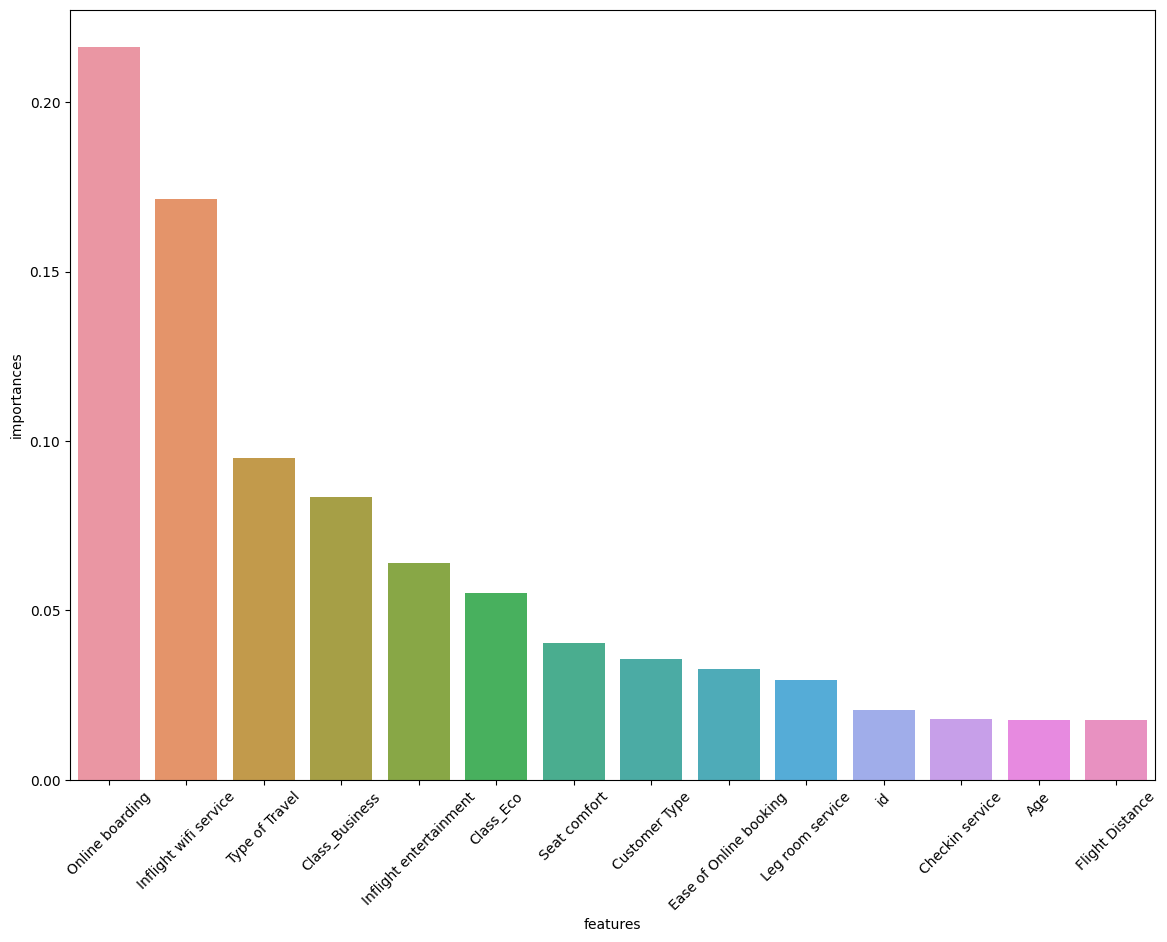

In [106]:
features = X.columns
feature_importances = rf_best.feature_importances_
imp = pd.DataFrame({'features': features, 'importances': feature_importances})
imp = imp.sort_values(by='importances', ascending=False).iloc[:14]


plt.figure(figsize = (14, 10))
sns.barplot(data=imp,
            x='features',
            y='importances'
)
plt.xticks(rotation = 45);


## **Бустинг**

In [118]:

airpass = pd.read_csv('data/AirPass.zip', index_col=0)
airpass.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [119]:
airpass.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103904 entries, 0 to 103903
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 103904 non-null  int64  
 1   Gender                             103904 non-null  object 
 2   Customer Type                      103904 non-null  object 
 3   Age                                103904 non-null  int64  
 4   Type of Travel                     103904 non-null  object 
 5   Class                              103904 non-null  object 
 6   Flight Distance                    103904 non-null  int64  
 7   Inflight wifi service              103904 non-null  int64  
 8   Departure/Arrival time convenient  103904 non-null  int64  
 9   Ease of Online booking             103904 non-null  int64  
 10  Gate location                      103904 non-null  int64  
 11  Food and drink                     103904 no

**Задание 6.1**

Для начала сделаем небольшую предобработку данных. Сколько всего в данных пропущенных значений?

In [120]:
airpass.isna().sum().sum()

310

**Задание 6.2**

Теперь давайте избавимся от найденных пропусков. Заполните их все медианными значениями. После этого вычислите среднее арифметическое для признака, отражающего задержку при прибытии в минутах. Ответ округлите до двух знаков после точки-разделителя.

In [121]:
airpass.fillna({'Arrival Delay in Minutes': airpass['Arrival Delay in Minutes'].median()}, inplace=True)
airpass['Arrival Delay in Minutes'].mean().round(2)

15.13

**Задание 6.3**

Проведём небольшой разведывательный анализ. Посмотрим, в каких категориях пассажиров превалировали удовлетворённые полетом клиенты.

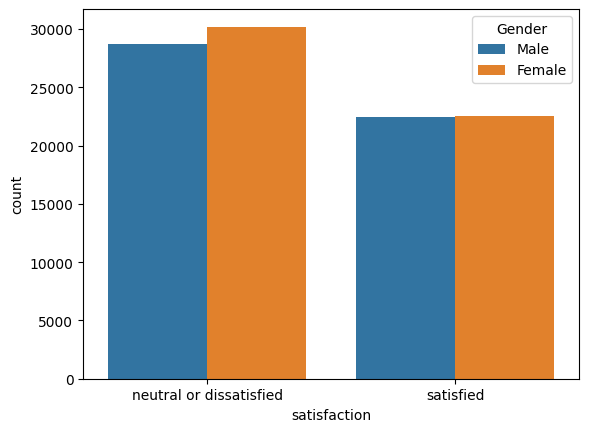

In [122]:
# Сравните удовлетворённость полётом мужчин и женщин

sns.countplot(data=airpass, x='satisfaction', hue='Gender');

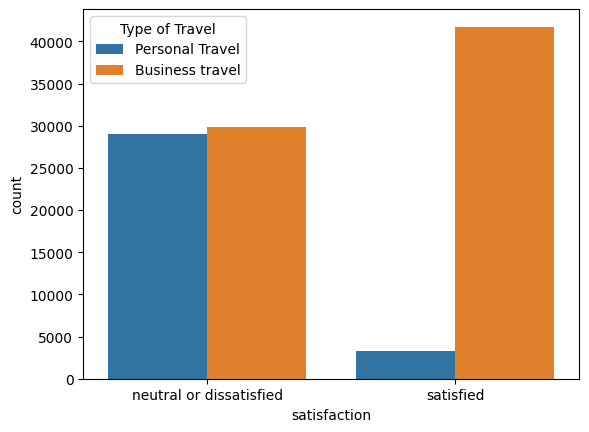

In [123]:
# 2. Теперь сравним категории пассажиров в зависимости от их цели поездки
sns.countplot(data=airpass, x='satisfaction', hue='Type of Travel');

In [124]:
# 3. В каком туристическом классе наибольший процент довольных клиентов?

airpass.groupby(['Class', 'satisfaction']).satisfaction.count()/airpass.groupby('Class').satisfaction.count()*100

Class     satisfaction           
Business  neutral or dissatisfied    30.574852
          satisfied                  69.425148
Eco       neutral or dissatisfied    81.386245
          satisfied                  18.613755
Eco Plus  neutral or dissatisfied    75.393648
          satisfied                  24.606352
Name: satisfaction, dtype: float64

In [125]:
# Перекодируем часть бинарных признаков, чтобы использовать их при обучении

airpass['satisfaction'] = airpass['satisfaction'].map({'neutral or dissatisfied':0 , 'satisfied':1})
airpass['Customer Type'] = airpass['Customer Type'].map({'Loyal Customer':1, 'disloyal Customer':0})
airpass['Type of Travel'] = airpass['Type of Travel'].map({'Personal Travel':0, 'Business travel':1})
airpass['Gender'] = airpass['Gender'].map({'Male': 0, 'Female': 1})

**Задание 6.4**

Для остальных категориальных признаков создайте dummy-переменные. Сделайте это с помощью функции get_dummies() из библиотеки Pandas, параметры не меняйте. Сколько теперь признаков в данных (включая целевую переменную)?

In [126]:
cat = airpass.select_dtypes(include=['category', 'object']).columns

airpass = pd.get_dummies(airpass, columns=cat)

len(airpass.columns)

26

**Задание 6.5**

Мы практически добрались до обучения модели. Разбейте данные на обучающую и тестовую выборки в соотношении 80/20, параметр random_state = 26. Сколько наблюдений попало в тестовую выборку?

In [127]:
X = airpass.drop('satisfaction', axis = 1)
Y = airpass['satisfaction']  
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state = 26)
X_test.shape[0]

20781

**Задание 6.6**

Теперь нам необходимо реализовать масштабирование данных. Для этого обучите на обучающей выборке метод StandardScaler() и с помощью него преобразуйте и обучающую, и тестовую выборки. Не забудьте, что целевую переменную обрабатывать не нужно.

Примечание. Отметим, что если бы дальше мы работали только с деревьями, масштабирование бы не требовалось. Однако мы реализуем его, чтобы можно было обучать и другие модели и сравнивать полученные результаты.

В качестве ответа введите самое первое значение из матрицы преобразованных признаков тестовой выборки

In [128]:
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_test_scaled[0][0].round(2)


0.94

**Задание 6.7**

Перейдём к обучению моделей. В качестве первой модели возьмём самую простую — логистическую регрессию. Мы делаем это для того, чтобы потом сравнивать с ней полученные результаты: так вы сможете выяснить, насколько ансамбли смогут улучшить точность прогноза.

Обучите логистическую регрессию с параметрами по умолчанию на наших данных. В качестве ответа введите значение метрики f1_score. Ответ округлите до трёх знаков после точки-разделителя.

In [129]:
lr = linear_model.LogisticRegression().fit(X_train_scaled, Y_train)

Y_pred_6_7 = lr.predict(X_test_scaled)

round(metrics.f1_score(Y_test, Y_pred_6_7), 3)

0.855

**Задание 6.8**

Теперь перейдём к бустингу. Начнём с обучения первой модели — AdaBoost. В качестве базовой модели для неё возьмите решающее дерево с параметром random_state = 26.

Обучите AdaBoost, зафиксировав random_state со значением 26 и задав темп обучения 0.01. В качестве ответа введите значение метрики f1_score. Ответ округлите до трёх знаков после точки-разделителя.

In [130]:
ab = ensemble.AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(random_state=26),
                                 learning_rate=0.01,
                                 random_state=26
).fit(X_train_scaled, Y_train)

Y_pred_6_8 = ab.predict(X_test_scaled)

round(metrics.f1_score(Y_test, Y_pred_6_8), 3)

0.94

**Задание 6.9**

Перейдем к следующему алгоритму — градиентному бустингу.

Будем настраивать количество деревьев и темп обучения, делая перебор по сетке.

Используйте для поиска оптимальных параметров GridSearchCV, а для ускорения работы алгоритма задайте параметр кросс-валидации, равный 3.

Какое наибольшее значение метрики f1_score получилось? Ответ округлите до трёх знаков после точки-разделителя.

In [134]:
params = {"n_estimators":2**np.arange(8),
          "learning_rate":0.1**np.arange(3)
}

gs_gb = model_selection.GridSearchCV(
    estimator=ensemble.GradientBoostingClassifier(), 
    param_grid=params, 
    cv=3,
    scoring=metrics.make_scorer(metrics.f1_score),
)  
gs_gb.fit(X_train_scaled, Y_train)
round(gs_gb.best_score_, 3)


0.949

**Задание 6.10**

Обучите алгоритм XGBoost. Так как он достаточно мощный «из коробки», определите его с параметрами по умолчанию, только задайте random_state = 26. Какое значение метрики f1_score получилось? Ответ округлите до трёх знаков после точки-разделителя.

In [140]:
xb = xgboost.XGBClassifier(random_state = 26).fit(X_train_scaled, Y_train)

Y_pred_6_10 = xb.predict(X_test_scaled)
round(metrics.f1_score(Y_pred_6_10, Y_test), 3)

0.957

**Задание 6.11**

Обучите алгоритм CatBoost. Как и XGBoost, будем обучать его с настройками по умолчанию и заданным random_state = 26. Какое значение метрики f1_score получилось? Ответ округлите до трёх знаков после точки-разделителя.

In [144]:
cb = CatBoostClassifier(random_state = 26).fit(X_train_scaled, Y_train)

Y_pred_6_11 = cb.predict(X_test_scaled)
round(metrics.f1_score(Y_test, Y_pred_6_11), 3)

Learning rate set to 0.068023
0:	learn: 0.6018138	total: 173ms	remaining: 2m 52s
1:	learn: 0.5020760	total: 199ms	remaining: 1m 39s
2:	learn: 0.4472472	total: 223ms	remaining: 1m 14s
3:	learn: 0.4028682	total: 243ms	remaining: 1m
4:	learn: 0.3674730	total: 263ms	remaining: 52.3s
5:	learn: 0.3397846	total: 283ms	remaining: 46.9s
6:	learn: 0.3121210	total: 302ms	remaining: 42.8s
7:	learn: 0.2917499	total: 319ms	remaining: 39.5s
8:	learn: 0.2749040	total: 332ms	remaining: 36.6s
9:	learn: 0.2575190	total: 346ms	remaining: 34.3s
10:	learn: 0.2473691	total: 360ms	remaining: 32.3s
11:	learn: 0.2377531	total: 372ms	remaining: 30.6s
12:	learn: 0.2279311	total: 385ms	remaining: 29.2s
13:	learn: 0.2212512	total: 398ms	remaining: 28s
14:	learn: 0.2100358	total: 413ms	remaining: 27.1s
15:	learn: 0.2025732	total: 426ms	remaining: 26.2s
16:	learn: 0.1942301	total: 440ms	remaining: 25.4s
17:	learn: 0.1877938	total: 456ms	remaining: 24.9s
18:	learn: 0.1832380	total: 471ms	remaining: 24.3s
19:	learn: 0.

0.96

**Задание 6.12**

Выведите матрицу ошибок для алгоритма, который получил наилучшие показатели качества модели на обучающей выборке (будем считать, что оцениваем по f1_score). 
Значения в матрице ошибок переведите в проценты от общего числа наблюдений в обучающей выборке и округлите до целых.

In [147]:
(get_confusion_matrix(cb, Pool(X_train_scaled, Y_train))/len(X_train_scaled)*100).round()

array([[56.,  1.],
       [ 2., 42.]])

**Задание 6.13**

Оцените важность признаков для модели из предыдущего задания.

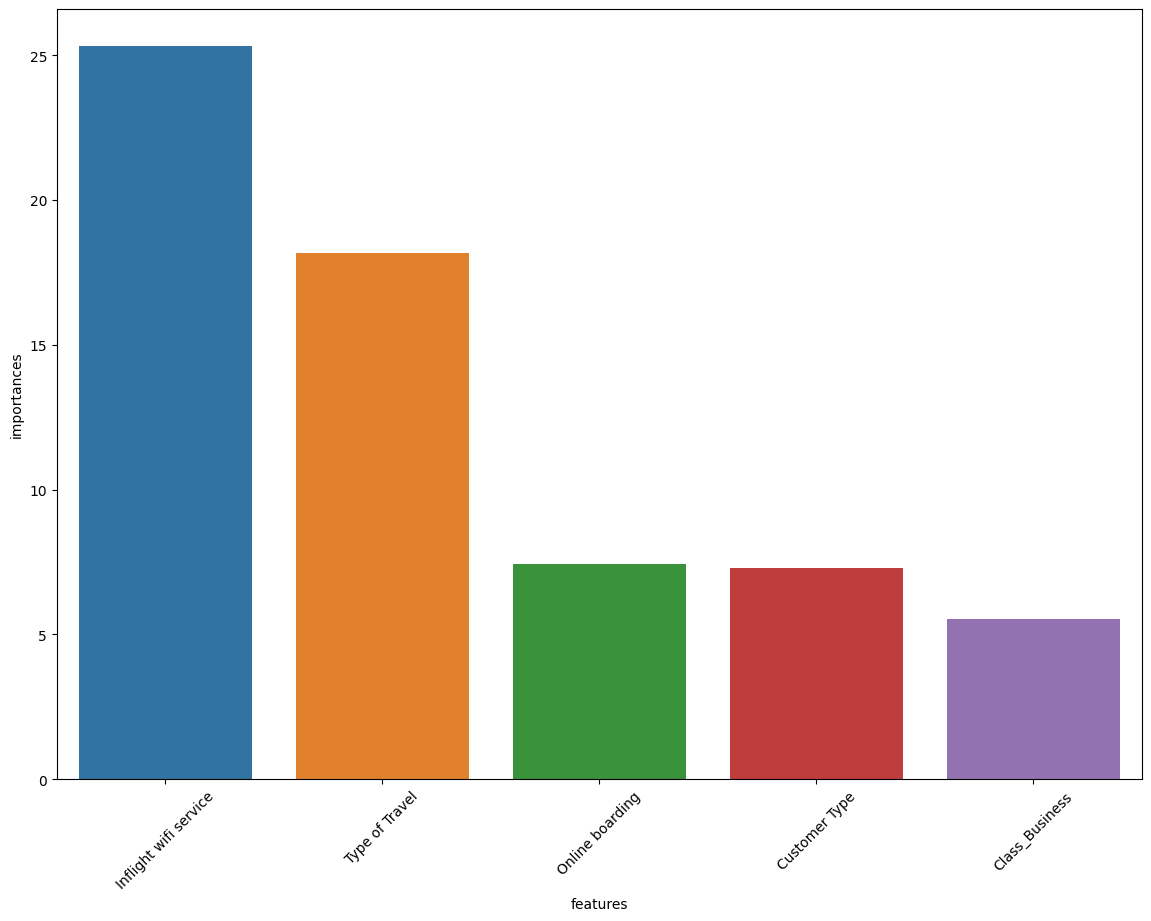

In [148]:
features = X.columns
feature_importances = cb.feature_importances_
imp = pd.DataFrame({'features': features, 'importances': feature_importances})
imp = imp.sort_values(by='importances', ascending=False).iloc[:5]


plt.figure(figsize = (14, 10))
sns.barplot(data=imp,
            x='features',
            y='importances'
)
plt.xticks(rotation = 45);

## **Стекинг**

In [165]:
frogs = pd.read_csv('data/Frogs_MFCCs.zip').drop(['Genus',
                                                  'Species',
                                                  'RecordID'
                                                  ],
                                                  axis=1
)
frogs.head()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,0.082245,0.135752,-0.024017,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,0.022786,0.163320,0.012022,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,0.050791,0.207338,0.083536,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.011567,0.100413,-0.050224,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,0.037439,0.219153,0.062837,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae


In [166]:
X = frogs.drop('Family', axis = 1)
Y = frogs.Family.apply(lambda x: 1 if x == 'Dendrobatidae' else 0)  
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state = 31)
X_test.shape

(1439, 22)

**Задание 7.5**

Для начала обучите на наших данных случайный лес с десятью решающими деревьями. Воспользуйтесь параметрами по умолчанию. В качестве значения random_state возьмите число 42.

Оцените значение $F1$-меры и введите его в качестве ответа, предварительно округлив до двух знаков после точки-разделителя.

In [167]:
rfc_7_5 = ensemble.RandomForestClassifier(n_estimators=10, random_state=42).fit(X_train, Y_train)
Y_7_5 = rfc_7_5.predict(X_test)
round(metrics.f1_score(Y_7_5, Y_test), 2)

0.97

**Задание 7.6**

Теперь попробуем улучшить качество нашего предсказания за счёт использования стекинга.

В качестве базовых моделей выберите следующие:

- случайный лес с десятью деревьями, random_state = 31;
- KNN, количество соседей = 11;
- наивный байесовский классификатор с параметрами по умолчанию, в качестве метода возьмите GaussianNB().

В качестве метамодели выберите логистическую регрессию.

Обучите модели и сделайте предсказание целевой метки для тестового набора данных.

Рассчитайте $F1$-меру для тестового набора данных и введите её в качестве ответа, предварительно округлив до двух знаков после точки-разделителя.

In [179]:
estimators = [('rfc', ensemble.RandomForestClassifier(n_estimators=10, random_state=31)),
            ('knn', neighbors.KNeighborsClassifier(n_neighbors=11)),
            ('dt',  naive_bayes.GaussianNB())
]

str_7_6 = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression()
).fit(X_train, Y_train)

Y_7_6 = str_7_6.predict(X_test)
round(metrics.f1_score(Y_7_6, Y_test), 2)

AttributeError: 'Flags' object has no attribute 'c_contiguous'